In [22]:
import numpy as np
from NonlinearController.mpc_utils import *
# from NonlinearController.controllers import *
from NonlinearController.model_utils import *
from NonlinearController.lpv_embedding import *
from NonlinearController.systems import UnbalancedDisc, FullUnbalancedDisc, ReversedFullUnbalancedDisc
from NonlinearController.models import *
import matplotlib.pyplot as plt
import deepSI
import qpsolvers as qp
import torch
import random
from NonlinearController.utils import *

In [23]:
##################  System  #######################
dt = 0.1
system = FullUnbalancedDisc(dt=dt, sigma_n=[0.0])
system.reset_state()

##################  MPC variable specification  #######################
Nc=5; nr_iterations = 10; nr_sim_steps = 60

w_max = 6; w_min = -w_max
q_min = [-1.2,-1.2]; q_max = [1.2,1.2] # augmented with the velocity states
w0 = 0; q0 = [0.0,1.0]#q0 = [np.sin(0), np.cos(0)]# q0 = np.array([[1,2]]).T

In [24]:
a = 2.7; reference_theta = np.hstack((np.ones(20)*a,np.ones(20)*a,np.ones(60)*a))
# reference_theta = np.sin(np.arange(0,50)/np.pi*1.5)*2
# reference_theta = randomLevelReference(nr_sim_steps+Nc, [10,15], [-3.1,3.1])
reference = np.vstack((np.sin(reference_theta),np.cos(reference_theta)))

In [28]:
# N = 10
# u = np.random.uniform(-1,1,N)

# system.reset_state()

# log_x_Cas = np.zeros((N+1, nx)); log_x_Cas[0,:] = system.x
# log_x_SI = np.zeros((N+1, nx)); log_x_SI[0,:] = system.x
# log_u = np.zeros((N, nu))

# for i in range(N):
#     system.x = system.f(system.x, u[i])
#     log_x_SI[i+1,:] = system.x

#     log_x_Cas[i+1,:] = np.array(f_rk4(log_x_Cas[i,:], u[i]))[:,0]


In [30]:
##################  Offline Computation  #######################
# Temporary hardcoded variables
nx = 2
nu = 1
ny = 2
nz = nx+ny
ne = 1

# initialize objective function matrices
# Q1 = np.eye(ny)*500
Q1 = np.zeros((ny,ny)); np.fill_diagonal(Q1, [500, 500])
Q2 = np.zeros((nz,nz)); Q2[ny:,ny:] = np.eye(nx)
Omega1 = get_Omega(Nc, Q1)
Omega2 = get_Omega(Nc, Q2)

R = np.eye(nu)*0.1;# Q = np.zeros((nz,nz)); np.fill_diagonal(Q, [200.,200.,1.,1.]) #Q = np.matrix('10,0,0;0,10,0;0,0,10')# these are user defined
Psi = get_Psi(Nc, R)
# Omega = get_Omega(Nc, Q)

# extended objective matrices for soft constraints
e_lambda = 1e8 # weighting of minimizing e in objective function
Ge = np.zeros((Nc*nu+ne,Nc*nu+ne)) 
Ge[-ne:,-ne:] = e_lambda

embedder = CasADi_velocity_lpv_embedder(Nc=Nc, n_stages=20)

# normalize initial input and output
norm = normalizer(np.array([0.0,0.0]), np.array([1.0,1.0]), 0, 1)#model.norm
u0 = norm_input(w0, norm)
y0 = norm_output(q0, norm)

# determine constraint matrices
u_min = norm_input(w_min, norm); u_max = norm_input(w_max, norm)
y_min = np.hstack((norm_output(q_min, norm), np.ones(nx)*-1000)); y_max = np.hstack((norm_output(q_max, norm), np.ones(nx)*1000)) # augmented with the velocity states
D, E, M, c = getDEMc(y_min, y_max, u_min, u_max, Nc, nz, nu)
Lambda = np.tril(np.ones((Nc,Nc)),0)

# initialize observer history input and output
# nb = model.nb
# uhist = torch.from_numpy(np.tile(u0,nb+1)).T
# uhist = torch.ones((1,nb))*u0
# na = model.na
# yhist = torch.from_numpy(np.tile(y0,na+1)).T
# yhist = torch.ones((1,na+1))*y0

# initial predicted states, input, and output
X_1 = np.tile(np.zeros((1,2)),Nc+2).T
U_1 = np.ones((Nc+1)*nu)[np.newaxis].T*u0
Y_1 = np.tile(y0[np.newaxis],Nc).T

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))
log_w = np.zeros((nu,nr_sim_steps))
log_e = np.zeros((ne,nr_sim_steps))
log_iterations = np.zeros((1,nr_sim_steps))
log_comp_t = np.zeros((4, nr_sim_steps*nr_iterations))

offset = 0
e = 0 #initial value for soft bounds for hotstart

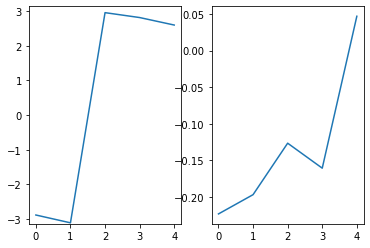

In [709]:
##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    # extend normalized reference to form of extended state
    # r = extendReference((reference[:,k:k+Nc] - norm.y0[np.newaxis].T)/norm.ystd[np.newaxis].T, nx, ny, Nc) 
    # r = extendReference(reference[:,k:k+Nc], nx, ny, Nc)
    r = extendReference(reference[:,k:k+Nc], 0, ny, Nc)
    # r = np.tile(reference[:,k:k+1].T,Nc).T
    
    #++++++++++++++++++ start iteration +++++++++++++++++++++++
    for iteration in range(nr_iterations):
        # determine predicted velocity states and output
        dX0 = differenceVector(X_1[:nx*(Nc+1)], nx)
        dU0 = differenceVector(U_1, nu)
        # determine extended state from predicted output and velocity states
        Z0 = extendState(Y_1, dX0, nx, ny, Nc)

        # determine lpv state space dependencies
        list_A, list_B, list_C = embedder(X_1, U_1)
        list_ext_A, list_ext_B, list_ext_C = extendABC(list_A, list_B, list_C, nx, ny, nu, Nc)

        # describe optimization problem
        Z = getZ(list_ext_C,Nc,ny,nz)
        Phi = get_Phi(list_ext_A, Nc, nz)
        Gamma = get_Gamma(list_ext_A, list_ext_B, Nc, nz, nu)
        G = 2*(Gamma.T @ (Z.T @ Omega1 @ Z + Omega2) @ Gamma)
        F = 2*(Gamma.T @ (Z.T @ Omega1 @ (Z @ Phi @ Z0[:nz] - r) + Omega2 @ Phi @ Z0[:nz]))
        # G = 2*(Psi + Gamma.T @ Omega @ Gamma)
        # F = 2*(Gamma.T @ Omega @ (Phi @ Z0[:nz] - r))
        # describe constraints
        L = (M @ Gamma + E @ Lambda)
        alpha = np.ones((Nc,1))*U_1[0,0]
        W = -(E @ alpha + (D + M @ Phi) @ Z0[:nz])
        # add soft constraints
        Ge[:Nc*nu, :Nc*nu] = G
        Fe = np.vstack((F, np.zeros((ne,1))))
        Le = np.hstack((L, -np.ones((Nc*2*(nz+nu)+2*nz,ne))))

        # solve for optimal U over prediction horizon
        # opt_result = qp.solve_qp(Ge,Fe,Le,c+W,solver="osqp",initvals=np.hstack((dU0[:,0],e)))
        # opt_result = qp.solve_qp(Ge,Fe,Le,c+W,solver="osqp")
        opt_result = qp.solve_qp(Ge,Fe,solver="osqp",initvals=np.hstack((dU0[:,0],e)))
        # split optimization result in optimal input and soft bound variable e
        dU0[:,0] = opt_result[:Nc*nu]
        e = opt_result[-ne]
        
        # predict states
        Z1 = Phi @ Z0[:nz] + Gamma @ dU0
        # split extended state up into ouputs and velocity states
        Y0, dX1 = decodeState(Z1, nx, ny, Nc)
        # overwrite previous predicted states and output with new predicted states and output
        Y_1[2*ny:,0] = Y0[ny:-ny,0]; dX0[nx:,0] = dX1[:-nx,0] #change the shifting on the output to be consequential
        # save previous iteration of U_1
        U_1_old = np.copy(U_1)
        # determine new X_1 states from known x0 and predicted dX0
        for i in range(2,Nc+1):
            X_1[(i*nx):(i*nx+nx),:] = dX0[((i-1)*nx):((i-1)*nx+nx),:] + X_1[((i-1)*nx):((i-1)*nx+nx),:]
        X_1[-nx:,:] = dX1[-nx:,:] + X_1[-2*nx:-nx,:]
        for i in range(2,Nc+1):
            U_1[(i*nu):(i*nu+nu),:] = dU0[((i-1)*nu):((i-1)*nu+nu),:] + U_1[((i-1)*nu):((i-1)*nu+nu),:]

        if k==13 and iteration==0:
            plt.subplot(1,2,1)
            sinCos =  np.hstack(np.split(Y0,Nc))
            theta = np.arctan2(sinCos[0,:], sinCos[1,:])
            plt.ylim((-np.pi,np.pi))
            plt.plot(theta)
            # plt.plot(Y0[:,0])

            plt.subplot(1,2,2)
            dOmegaTheta = np.hstack(np.split(dX1,Nc))
            plt.plot(dOmegaTheta[1,:])
            plt.show()

        # stopping condition
        if np.linalg.norm(U_1 - U_1_old) < 1e-1:
            break
    #++++++++++++++++++ end iteration +++++++++++++++++++++++
    
    # determine input from optimal velocity input
    u0 = dU0[:nu,0] + U_1[:nu,0]
    # denormalize input
    w0 = denorm_input(u0, norm)
    # measure output then apply input
    system.x = system.f(system.x, w0[0])
    omega1, theta1 = system.h(system.x, w0[0])
    q1 = np.array((np.sin(theta1), np.cos(theta1)))
    # normalize output
    y1 = norm_output(q1, norm)

    # shift history input and output for encoder
    # for j in range(nb-1):
    #     uhist[0,j] = uhist[0,j+1]
    # uhist[0,nb-1] = torch.Tensor(u0)
    # for j in range(na):
    #     yhist[0,j] = yhist[0,j+1]
    # yhist[0,na] = torch.Tensor([y1])
    # # predict state with encoder
    # x1 = model.encoder(uhist,yhist)
    x1 = np.vstack((omega1, theta1))

    # shift predicted states, input, and output one time step k; and replace with measured/observed values
    X_1[:-nx, :] = X_1[nx:, :]; X_1[-nx:, :] = X_1[-2*nx:-nx, :]; X_1[nx:2*nx, :] = x1
    U_1[:-nu, :] = U_1[nu:, :]; U_1[-nu:, :] = U_1[-2*nu:-nu, :]; U_1[:nu, :] = u0
    Y_1[:-ny, :] = Y_1[ny:, :]; Y_1[-ny:, :] = Y_1[-2*ny:-ny, :]; Y_1[ny:2*ny, :] = y1[np.newaxis].T

    # log system signals
    log_q[:,k] = q1
    log_w[:,k] = w0
    log_e[:,k] = e
    log_iterations[:,k] = iteration+1
    
    # print progress
    # print("Sim step: " + str(k) + ", iterations: " + str(iteration+1))
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++

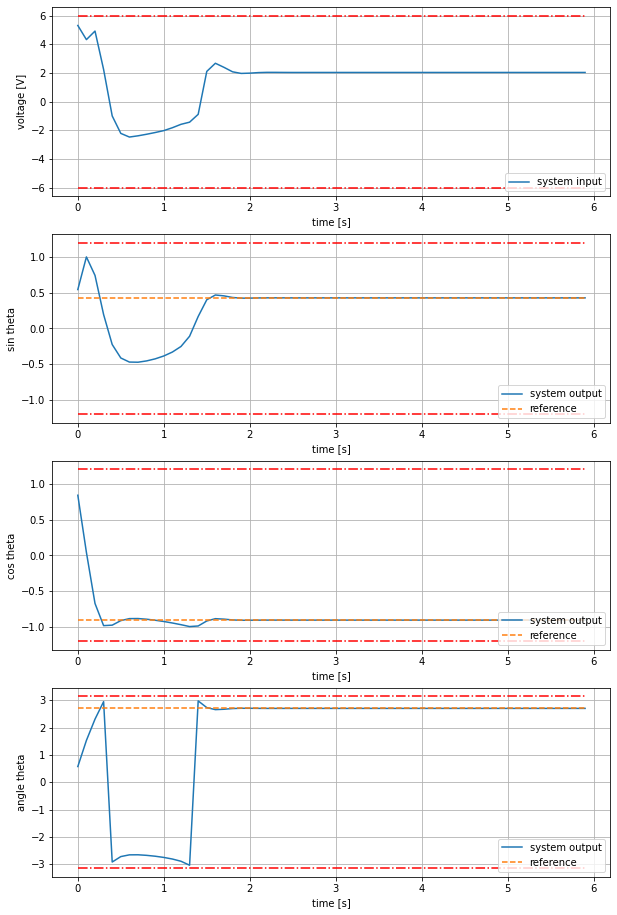

In [710]:
# logs from other scripts
log_q_nmpc = np.load("NonlinearController/experiments/log_q.npy")
log_w_nmpc = np.load("NonlinearController/experiments/log_w.npy")
log_u_lpv = np.load("NonlinearController/experiments/u_log.npy")
log_y_lpv = np.load("NonlinearController/experiments/y_log.npy")

fig1 = plt.figure(figsize=[10, 16])
# fig1 = plt.figure(figsize=[16, 8])

plt.subplot(4,1,1)
plt.plot(np.arange(nr_sim_steps)*dt, log_w[0,:], label='system input')
# plt.plot(np.arange(nr_sim_steps)*dt, np.hstack((log_u_lpv[1:],log_u_lpv[-1])), label='lpv input')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_min, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='lower right')


plt.subplot(4,1,2)
plt.plot(np.arange(nr_sim_steps)*dt, log_q[0,:], label='system output')
plt.plot(np.arange(nr_sim_steps)*dt, np.hstack((reference[0,:nr_sim_steps])), '--', label='reference')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_max[0], 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_min[0], 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("sin theta")
plt.grid()
plt.legend(loc='lower right')

plt.subplot(4,1,3)
plt.plot(np.arange(nr_sim_steps)*dt, log_q[1,:], label='system output')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_max[1], 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_min[1], 'r-.')#, label='min')
# plt.plot(np.arange(nr_sim_steps)*dt, np.hstack((log_y_lpv[2:],log_y_lpv[-1])), label='lpv output')
plt.plot(np.arange(nr_sim_steps)*dt, np.hstack((reference[1,:nr_sim_steps])), '--', label='reference')
# plt.plot(np.arange(nr_sim_steps)*dt, log_q[0,:] - log_q_nmpc[0,:], label='vel-nmpc')
plt.xlabel("time [s]")
plt.ylabel("cos theta")
plt.grid()
plt.legend(loc='lower right')

plt.subplot(4,1,4)
theta = np.arctan2(log_q[0,:], log_q[1,:])
plt.plot(np.arange(nr_sim_steps)*dt, theta, label='system output')
plt.plot(np.arange(nr_sim_steps)*dt, (reference_theta[1:nr_sim_steps+1]+np.pi)%(2*np.pi) - np.pi, '--', label='reference')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*np.pi, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, -np.ones(nr_sim_steps)*np.pi, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("angle theta")
plt.grid()
plt.legend(loc='lower right')

# plt.subplot(2,2,3)
# plt.plot(np.arange(nr_sim_steps)*dt, log_e[0,:], label='e')
# plt.xlabel("time [s]")
# plt.ylabel("e")
# plt.grid()
# plt.legend(loc='upper right')

# plt.subplot(2,2,4)
# plt.plot(np.arange(nr_sim_steps)*dt, log_iterations[0,:], label='iQP')
# plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*nr_iterations, 'r-.', label='max iter')
# plt.xlabel("time [s]")
# plt.ylabel("iterations")
# plt.grid()
# plt.legend(loc='upper right')

plt.show()

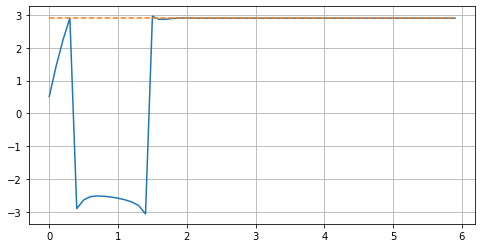

In [703]:
fig1 = plt.figure(figsize=[8, 4])
theta = np.arctan2(log_q[0,:], log_q[1,:])
plt.plot(np.arange(nr_sim_steps)*dt, theta)
plt.plot(np.arange(nr_sim_steps)*dt, (reference_theta[:nr_sim_steps]+np.pi)%(2*np.pi) - np.pi, '--')
plt.grid()

In [685]:
old_theta = theta

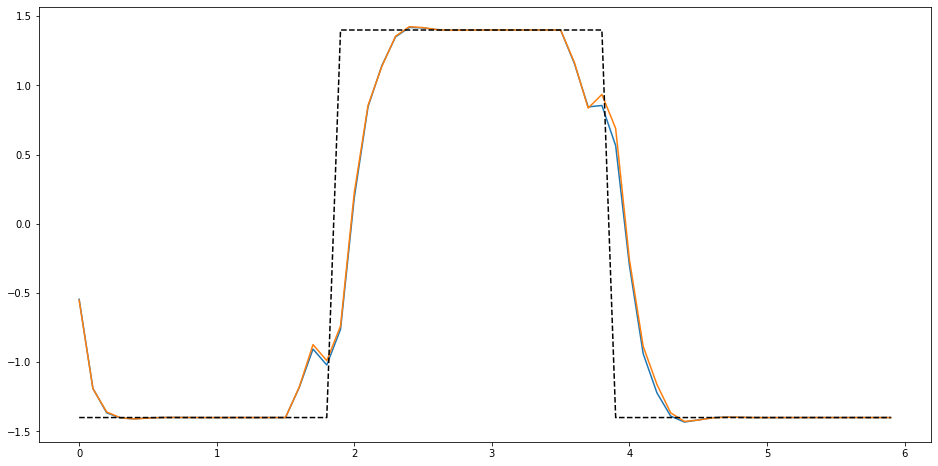

In [695]:
fig1 = plt.figure(figsize=[16, 8])
theta = np.arctan2(log_q[0,:], log_q[1,:])
plt.plot(np.arange(nr_sim_steps)*dt, theta)
plt.plot(np.arange(nr_sim_steps)*dt, old_theta)
# plt.plot(np.arange(nr_sim_steps)*dt, old_theta - theta)
plt.plot(np.arange(nr_sim_steps)*dt, (reference_theta[1:nr_sim_steps+1]+np.pi)%(2*np.pi) - np.pi, 'k--')

In [647]:
np.unique(log_iterations, return_counts=True)

(array([1., 2., 4., 5.]), array([13,  3,  3, 41], dtype=int64))

In [648]:
np.unique(log_iterations, return_counts=True)

(array([1., 2., 4., 5.]), array([13,  3,  3, 41], dtype=int64))